In this notebook we check the mean signal of the nuclei over the length of the movie. We also check the signal of background from the whole image.

## Load all necessary libraries 

In [3]:
import os
import math
import napari
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dask.array.image import imread as imr
from skimage import io, data

from nucleiBoxes import *

## Specify input and output paths and load image

In [4]:
homeFolder = '../demoData/'

imsQ = '11'
cellNumber = '4'
nameKey = 'Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_10ng.ml_tnf_exp1_4_F'

pathToTimeFrames = homeFolder+nameKey+imsQ+'/*.tif'
path_input = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'
pathToTimeFramesCell = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/*.tif'

stackCell = imr(pathToTimeFramesCell)
MaxTimePoint = stackCell.shape[0]
timeStack = imr(pathToTimeFrames)
maxImage = np.max(timeStack, axis=1)

## Load image segmentation mask

In [5]:
label_image_name = '../demoData/maxProject/T_MAX_Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_10ng_ml_tnf_exp1_4_F11_cp_masks.png'
label_image = io.imread(label_image_name)
# print(label_image_name)

/home/rachel/anaconda3/envs/imageAnalysis_2/lib/python3.8/site-packages/imageio/plugins/pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


## Draw background region in image 

On running the next cell, a napari viewer will open displaying the image and the segmentation results as well as the bounding box of the nuclei. Follow the steps below to draw a background:
1. Select the layer named "polygon"
2. Select the option Add Rectangle on the top most panel (or press the "R" key on the keyoard)
3. Close the viewer and run next cell with commented line "Get background"

In [6]:
cropBoxCoordinates, nucleiCentroids, nucleiNumbers, _ = getNucleiCoordinates(label_image_name, False)

polygon = []
for nuclei in range(len(cropBoxCoordinates)):
    bx = np.asarray(cropBoxCoordinates[nuclei][0])
    by = np.asarray(cropBoxCoordinates[nuclei][1])
    vertices = []
    for ii in range(len(bx)):
        vertices.append([by[ii], bx[ii]])
    polygon.append(vertices)

features = {
    'N': nucleiNumbers,
}
text = {
    'string': '{N:.1f}',
    'size': 8,
    'color': 'white',
    'translation': np.array([-20, 0]),
}

face_color_cycle = ['white']

viewer = napari.view_image(maxImage, colormap='green')
labels_layer = viewer.add_labels(label_image, name='segmentation',opacity=0.3)
shapes_layer = viewer.add_shapes(polygon, shape_type='polygon', edge_width=2,
                          edge_color='white', face_color='#00000000', opacity=0.3)
points_layer = viewer.add_points(
    nucleiCentroids,
    features=features,
    text=text,
    size=2,
    edge_width=2,
    edge_width_is_relative=False,
    edge_color='N',
    edge_colormap='gray',
    face_color_cycle=face_color_cycle,
    name = 'nuclei Label'
)

## Get background and its bounding box coordinates

In [6]:
# Get background

random_box = shapes_layer.data[-1]

coord=[]
minc = int(np.round(random_box[0][1]))
minr = int(np.round(random_box[0][0]))
maxc = int(np.round(random_box[2][1]))
maxr = int(np.round(random_box[2][0]))

bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
coord.append([bx, by, minc,minr])


## Calculate mean signal intensity within nuclei, cytoplasmic, background image

/home/rachel/anaconda3/envs/imageAnalysis_2/lib/python3.8/site-packages/imageio/plugins/pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


Text(0.5, 1.0, 'Mean intensity over time')

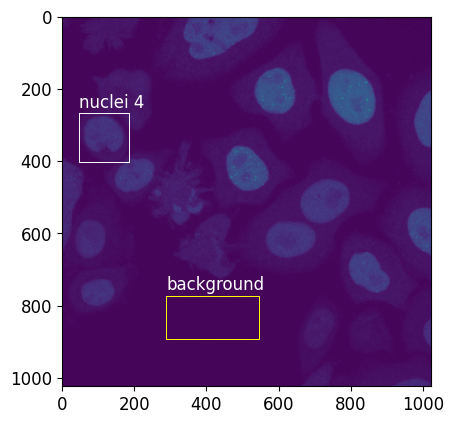

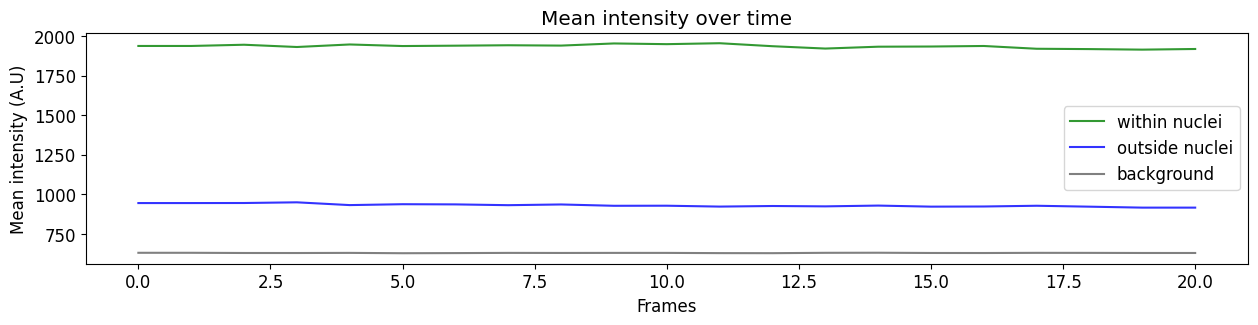

In [9]:
cellNumber=4
plt.rcParams['font.size'] = 12
t=880
path_input = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'
nucleiStackForm = nameKey+imsQ+"_cell_"
nucleiStackName = nucleiStackForm+str(cellNumber)+'_t'+str(f"{t:03}")+".tif"
nucleiStackPath = os.path.join(path_input, nucleiStackName)
labeldf = pd.read_pickle(moviePath+"LabelDF.pkl")  
maxTimePoint = MaxTimePoint
path_input =homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'


#----------------------------------- For background --------------------------------#
moviePath = homeFolder+nameKey+imsQ+'/'
test = getBackgroundTimeProfile(moviePath, nameKey, imsQ, minc, minr, maxc, maxr, start=880, stop=900, extensionF='.tif')


#---------------------------- Within and outside nuclei-----------------------------#

meanofRandomImageSample_w, meanofRandomImageSample_o = getTimeProfile(path_input, nucleiStackForm, cellNumber, label_image_name, labeldf, 880,900)

nucIdx = np.where(labeldf['label']==np.int64(cellNumber))
minr = labeldf.loc[nucIdx]['minr'].values[0]
minc = labeldf.loc[nucIdx]['minc'].values[0]
maxr = labeldf.loc[nucIdx]['maxr'].values[0]
maxc = labeldf.loc[nucIdx]['maxc'].values[0]


#------------------------------Plot results ---------------------------------------#
plt.figure(num=25)
plt.imshow(maxImage[0])
plt.plot((minc, maxc, maxc, minc, minc), (minr, minr, maxr, maxr, minr), '-w', linewidth=.7)

plt.text(coord[0][0][0],coord[0][1][1]*0.98, s='background', color='white')
plt.plot(bx, by, linewidth=.7, color='yellow')
plt.text(minc, minr*0.95, s='nuclei '+str(cellNumber), color='white')
# percentageLoss = ((np.mean(meanofRandomImageSample,axis=0)[0]-np.mean(meanofRandomImageSample,axis=0)[-1])/np.mean(meanofRandomImageSample,axis=0)[0])*100

plt.figure(num=4, figsize=(15,3))
plt.plot(meanofRandomImageSample_w,  label='within nuclei', color='green', alpha=0.8)
plt.plot(meanofRandomImageSample_o,  label='outside nuclei', color='blue', alpha=0.8)

plt.plot(test, label= 'background', color='grey')
plt.legend(labelcolor='black')
plt.xlabel('Frames')
plt.ylabel('Mean intensity (A.U)')
plt.title('Mean intensity over time')